# Clustering d'Images avec Scikit-learn et Visualisation avec Streamlit

Le clustering est une technique d'apprentissage non supervisé qui permet de regrouper des données similaires en différents groupes ou clusters. Dans le contexte de l'analyse d'images, le clustering peut être utilisé pour segmenter des images, détecter des objets ou des régions d'intérêt, et comprendre la structure des données d'image. Ce TP vous guidera à travers le processus de clustering d'un ensemble d'images de chiffres manuscrits en utilisant l'algorithme K-Means et l'extraction de caractéristiques HOG et d'histogrammes de niveaux de gris. Vous visualiserez ensuite les résultats du clustering à l'aide de la bibliothèque Streamlit.


À la fin de ce TP, vous aurez une compréhension pratique du processus de clustering d'images, de l'extraction de caractéristiques, de l'évaluation des performances et de la visualisation des résultats à l'aide de Streamlit. Ces compétences sont précieuses dans de nombreux domaines tels que la vision par ordinateur, le traitement d'images médicales, l'analyse de données d'imagerie satellitaire, et bien d'autres.


In [26]:
from sklearn.preprocessing import StandardScaler
import os
import pandas as pd
from sklearn import datasets
import plotly as plt
import plotly.express as px
from features import *
from clustering import *
from utils import *
from constant import  PATH_OUTPUT, MODEL_CLUSTERING, PATH_DATA, PATH_DATA_AL



## Partie 1 : Création du modèle de clustering d'images
#### (fichier pipeline.py)

**1. Chargement des données d'images de chiffres manuscrits à partir du dataset Digits.**
   - Vous utiliserez le célèbre dataset Digitis qui contient des images de chiffres manuscrits. Ce dataset est souvent utilisé pour tester des algorithmes de reconnaissance de chiffres et d'apprentissage automatique.



In [ ]:
# GET IMAGES
import os
from PIL import Image
import numpy as np

def load_images_from_folder(folder):
    images = []
    labels_true = []
    folder_names = []
    for folder_number, sub_folder in enumerate(sorted(os.listdir(folder))):
        sub_folder_path = os.path.join(folder, sub_folder)
        if os.path.isdir(sub_folder_path):
            folder_names.append(sub_folder)
            for filename in sorted(os.listdir(sub_folder_path)):
                img_path = os.path.join(sub_folder_path, filename)
                if os.path.isfile(img_path):
                    img = Image.open(img_path)
                    img_matrix = np.array(img)
                    images.append(img_matrix)
                    labels_true.append(folder_number)
    return images, labels_true, folder_names

# Example usage:
folder_path = PATH_DATA_ALL + "/code_test"
images, labels_true, folder_names = load_images_from_folder(folder_path)

# Now you have a list of images as matrices and a corresponding list of folder numbers.
# Each image in the 'images' list corresponds to the folder number in the 'labels_true' list.

In [28]:
# affichage d'une image 
fig = px.imshow(images[0])

In [29]:
fig.show()

**2. Extraction SIFT.**

In [ ]:
descriptors_sift = compute_sift_descriptors(images)

**2. Extraction des caractéristiques HOG (Histogrammes de Gradients Orientés) et des histogrammes de niveaux de gris à partir des images.**
   - Les caractéristiques HOG capturent les informations de gradient et de bords dans les images, ce qui les rend utiles pour la reconnaissance d'objets et de formes.
   - Les histogrammes de niveaux de gris représentent la distribution des intensités de pixels dans l'image, fournissant des informations sur la texture et les motifs.

**TODO :**
   - Implémentez les fonctions `compute_hog_descriptors` et `compute_gray_histograms` dans  le fichier `features.py`, utilisez respectivement les fonctions `hog` de  la librairie `skimage` et  `calcHist` de `cv2`.
   - lien HOG : https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_hog.html
   - lien  histogrammes de niveaux de gris : https://pyimagesearch.com/2021/04/28/opencv-image-histograms-cv2-calchist/
   

In [9]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure

def compute_gray_histograms(images):
    """
    Calcule les histogrammes de niveau de gris pour les images MNIST.
    Input : images (list) : liste des images en niveaux de gris
    Output : descriptors (list) : liste des descripteurs d'histogrammes de niveau de gris
    """
    descriptors = []
    for image in images:
        # Convert image to uint8 format (required by cv2.calcHist)
        image_uint8 = image.astype(np.uint8)
        hist = cv2.calcHist([image_uint8], [0], None, [256], [0, 16])
        descriptors.append(hist.flatten())
    return descriptors

def compute_hog_descriptors(images):
    """
    Calcule les descripteurs HOG pour les images en niveaux de gris.
    Input : images (array) : tableau numpy des images
    Output : descriptors (list) : liste des descripteurs HOG
    """
    descriptors = []
    for image in images:
        fd, hog_image = hog(image, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualize=True)
        descriptors.append(fd)
        
        """fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
        
        ax1.axis('off')
        ax1.imshow(image, cmap=plt.cm.gray)
        ax1.set_title('Input image')
        
        # Rescale histogram for better display
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        
        ax2.axis('off')
        ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
        ax2.set_title('Histogram of Oriented Gradients')
        plt.show()"""
    
    return descriptors
    

In [10]:

print("\n\n ##### Extraction de Features ######")
print("- calcul features hog...")
descriptors_hog = compute_hog_descriptors(images)
print("- calcul features Histogram...")
descriptors_hist = compute_gray_histograms(images)



 ##### Extraction de Features ######
- calcul features hog...
- calcul features Histogram...



**3. Application de l'algorithme K-Means sur les caractéristiques extraites pour obtenir les clusters.**
   - L'algorithme K-Means est un algorithme de clustering populaire qui partitionne les données en K clusters en minimisant la somme des carrés des distances entre les points de données et les centroïdes des clusters.
   
   
 
 **TODO :**
   - Dans le fichier `clustering.py` implémentez les fonctions `initialize_centers()`, `nearest_cluster()` et `fit()` du KMeans.
   

In [11]:
class KMeans:
    def __init__(self, n_clusters=10, max_iter=300, random_state=None):
        """
        Initialise un objet KMeans.

        Entrées:
        - n_clusters (int): Le nombre de clusters à former (par défaut 8).
        - max_iter (int): Le nombre maximum d'itérations pour l'algorithme (par défaut 300).
        - random_state (int ou None): La graine pour initialiser le générateur de nombres aléatoires (par défaut None).
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        self.cluster_centers_ = None
        self.labels_ = None

    def initialize_centers(self, X):
        """
        Initialise les centres de clusters avec n_clusters points choisis aléatoirement à partir des données X.

        Entrée:
        - X (np.array): Les données d'entrée.

        Sortie:
        - Aucune sortie directe, mais les centres de clusters sont stockés dans self.cluster_centers_.
        """
        if self.random_state is not None:
            np.random.seed(self.random_state)

        # Randomly select n_clusters points as initial cluster centers
        indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        self.cluster_centers_ = X[indices]

    def nearest_cluster(self, X):
        """
        Calcule la distance euclidienne entre chaque point de X et les centres de clusters,
        puis retourne l'indice du cluster le plus proche pour chaque point.

        Entrée:
        - X (np.array): Les données d'entrée.

        Sortie:
        - np.array: Un tableau d'indices représentant le cluster le plus proche pour chaque point.
        """
        # Calculate Euclidean distances between each point and cluster centers
        distances = np.sqrt(((X[:, np.newaxis] - self.cluster_centers_)**2).sum(axis=2))

        # Get the index of the nearest cluster for each point
        nearest_cluster_indices = np.argmin(distances, axis=1)
        return nearest_cluster_indices

    def fit(self, X):
        """
        Exécute l'algorithme K-means sur les données X.

        Entrée:
        - X (np.array): Les données d'entrée.

        Sortie:
        - Aucune sortie directe, mais les centres de clusters sont stockés dans self.cluster_centers_.
        """
        # Initialize cluster centers
        self.initialize_centers(X)

        for _ in range(self.max_iter):
            # Assign each point to the nearest cluster
            self.labels_ = self.nearest_cluster(X)

            # Update cluster centers
            new_centers = np.array([X[self.labels_ == k].mean(axis=0) for k in range(self.n_clusters)])

            # Check for convergence
            if np.allclose(self.cluster_centers_, new_centers):
                break

            self.cluster_centers_ = new_centers

In [12]:
print("\n\n ##### Clustering ######")
print(np.array(descriptors_hog)[0])
number_cluster = 10
kmeans_hog = KMeans(n_clusters=number_cluster)
kmeans_hist = KMeans(n_clusters=number_cluster)

print("- calcul kmeans avec features HOG ...")
kmeans_hog.fit(np.array(descriptors_hog))
print("- calcul kmeans avec features Histogram...")
kmeans_hist.fit(np.array(descriptors_hist))



 ##### Clustering ######
[0.42270425 0.42270425 0.42270425 0.10335017 0.20486898 0.34151087
 0.35179412 0.41342715]
- calcul kmeans avec features HOG ...


- calcul kmeans avec features Histogram...


**4. Évaluation des performances du clustering en utilisant des métriques**
- Score AMI (Adjusted Mutual Information) : 
    Le score AMI renvoie une valeur de 1 lorsque les deux partitions sont identiques (c'est-à-dire parfaitement appariées). Les partitions aléatoires (étiquetages indépendants) ont un score attendu autour de 0.
    

In [13]:

print("\n\n##### Résultat ######")
metric_hist = show_metric(labels_true, kmeans_hist.labels_, descriptors_hist, bool_show=True, name_descriptor="HISTOGRAM", bool_return=True)
print("\n\n")
metric_hog = show_metric(labels_true, kmeans_hog.labels_, descriptors_hog,bool_show=True, name_descriptor="HOG", bool_return=True)




##### Résultat ######
########## Métrique descripteur : HISTOGRAM
Adjusted Mutual Information: 0.07769672243294264



########## Métrique descripteur : HOG
Adjusted Mutual Information: 0.15137967745185674


**5. Conversion des données de clustering au format requis pour la visualisation avec Streamlit.**

**TODO :**
- Dans le fichier `utils.py`, implémenter la fonction `conversion_3d` afin de convertir un vecteur de dimension n vers une dimension 3 pour a visualisation.
- Lien : https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [14]:
# list_dict = [metric_hist, metric_hog]
# df_metric = pd.DataFrame(list_dict)

# scaler = StandardScaler()
# descriptors_hist_norm = scaler.fit_transform(descriptors_hist)
# descriptors_hog_norm = scaler.fit_transform(descriptors_hog)

# #conversion vers un format 3D pour la visualisation
# x_3d_hist = conversion_3d(descriptors_hist_norm)
# x_3d_hog = conversion_3d(descriptors_hog_norm)

# # création des dataframe pour la sauvegarde des données pour la visualisation
# df_hist = create_df_to_export(x_3d_hist, labels_true, kmeans_hist.labels_)
# df_hog = create_df_to_export(x_3d_hog, labels_true, kmeans_hog.labels_)

# # Vérifie si le dossier existe déjà
# if not os.path.exists(PATH_OUTPUT):
#     # Crée le dossier
#     os.makedirs(PATH_OUTPUT)

# # sauvegarde des données
# df_hist.to_excel(PATH_OUTPUT+"/save_clustering_hist_kmeans.xlsx")
# df_hog.to_excel(PATH_OUTPUT+"/save_clustering_hog_kmeans.xlsx")
# df_metric.to_excel(PATH_OUTPUT+"/save_metric.xlsx")




***6. Création du fichier pipeline.py*** 
- Mettez au propre le code dans le fichier pipeline.py
- Puis exécutez :  `python pipeline.py `


***7. Analyse des résultats***
- Que penseez-vous des résultats que vous avez obtenu ?
- Relancer toute la pipeline avec un pré-traitement des images, comme augmenter le contrasse afin faire sortir la forme des objets. Et que remarquez-vous ?


## Partie 2 : Visualisation des résultats du clustering avec Streamlit
### (fichier dashboad_clustering.py)

Cette partie constituera le rendu final du TP. Nous développerons une application Streamlit pour visualiser et analyser les résultats du clustering.

L'application permettra de :

***1. Visualisation 3D du clustering***
- Nous créerons une visualisation 3D interactive des clusters obtenus, avec la possibilité de mettre en évidence un cluster spécifique et d'afficher des exemples d'images appartenant à ce cluster.

***TODO :***
- Utilizer la fonction `scatter_3d()` pour faire un plot 3D du clustering.
- lien : https://plotly.com/python/3d-scatter-plots/




In [15]:
import matplotlib.pyplot as plt
import plotly.express as px


***2. Métriques d'évaluation***
- Nous calculerons et afficherons diverses métriques d'évaluation, telles que le score AMI (Adjusted Mutual Information), pour quantifier la qualité du clustering obtenu avec chaque descripteur.

***TODO :*** 
- Utilisez la fonction `px.bar()` pour afficher un histogramme du score AMI.
- lien : https://plotly.com/python/horizontal-bar-charts/

In [16]:
graph_size = 300


***3. Finalisation du fichier dashboard_clustering.py***

***TODO :***
- Ajoutez les graphiques dans le fichier, puis lancez la commande :  `streamlit run dashboard_clustering.py `

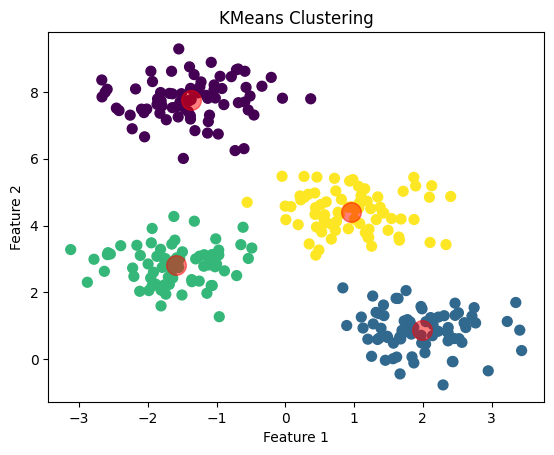

In [17]:
#KMEANS OPTIMIZED
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

# Générer des données synthétiques
X, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)

# Créer un objet KMeans avec 4 clusters
kmeans = KMeans(n_clusters=4)

# Adapter le modèle aux données
kmeans.fit(X)

# Prévoir les clusters pour chaque point de données
y_kmeans = kmeans.predict(X)

# Afficher les clusters et les centres
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('KMeans Clustering')
plt.show()

In [18]:
#3D PRINT
import plotly.express as px
df = px.data.iris()
fig = px.scatter_3d(df, x='sepal_length', y='sepal_width', z='petal_width',
              color='species')
fig.show()

c:\Users\comma\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotly\express\_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist

# Load and preprocess the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28*28) / 255.0
x_test = x_test.reshape(-1, 28*28) / 255.0

# Define RBM class
class RBM:
    def __init__(self, visible_dim, hidden_dim):
        self.visible_dim = visible_dim
        self.hidden_dim = hidden_dim
        self.W = tf.Variable(tf.random.normal([visible_dim, hidden_dim], mean=0.0, stddev=0.01), name="weights")
        self.b_visible = tf.Variable(tf.zeros([visible_dim]), name="visible_bias")
        self.b_hidden = tf.Variable(tf.zeros([hidden_dim]), name="hidden_bias")

    def sample_hidden(self, visible_prob):
        hidden_prob = tf.nn.sigmoid(tf.matmul(visible_prob, self.W) + self.b_hidden)
        return hidden_prob, tf.cast(tf.random.uniform(tf.shape(hidden_prob)) < hidden_prob, tf.float32)

    def sample_visible(self, hidden_prob):
        visible_prob = tf.nn.sigmoid(tf.matmul(hidden_prob, tf.transpose(self.W)) + self.b_visible)
        return visible_prob, tf.cast(tf.random.uniform(tf.shape(visible_prob)) < visible_prob, tf.float32)

# Create RBM layers
rbm1 = RBM(visible_dim=28*28, hidden_dim=500)
rbm2 = RBM(visible_dim=500, hidden_dim=500)

# Train RBMs layer by layer
def train_rbm(rbm, x_train, epochs=10, batch_size=64):
    for epoch in range(epochs):
        for i in range(0, len(x_train), batch_size):
            batch = x_train[i:i+batch_size]
            visible_prob = batch
            hidden_prob, _ = rbm.sample_hidden(visible_prob)
            new_visible_prob, _ = rbm.sample_visible(hidden_prob)
            
            positive_grad = tf.matmul(tf.transpose(visible_prob), hidden_prob)
            negative_grad = tf.matmul(tf.transpose(new_visible_prob), hidden_prob)
            
            rbm.W.assign_add(0.1 * (positive_grad - negative_grad) / tf.cast(tf.shape(batch)[0], tf.float32))
            rbm.b_visible.assign_add(0.1 * tf.reduce_mean(visible_prob - new_visible_prob, axis=0))
            rbm.b_hidden.assign_add(0.1 * tf.reduce_mean(hidden_prob - hidden_prob, axis=0))

train_rbm(rbm1, x_train, epochs=10)
train_rbm(rbm2, rbm1.sample_hidden(x_train)[0], epochs=10)

# Stack RBMs to form a deep belief network
class DBN:
    def __init__(self, rbm1, rbm2):
        self.rbm1 = rbm1
        self.rbm2 = rbm2
        self.model = Sequential([
            Dense(rbm1.hidden_dim, activation='sigmoid', input_shape=(28*28,)),
            Dense(rbm2.hidden_dim, activation='sigmoid')
        ])
        self.model.layers[0].set_weights([rbm1.W.numpy().T, rbm1.b_hidden.numpy()])
        self.model.layers[1].set_weights([rbm2.W.numpy().T, rbm2.b_hidden.numpy()])

# Fine-tune the network using supervised learning
def fine_tune(dbn, x_train, y_train, epochs=10):
    dbn.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    dbn.model.fit(x_train, y_train, epochs=epochs, batch_size=64)

dbn = DBN(rbm1, rbm2)
fine_tune(dbn, x_train, y_train, epochs=10)

# Evaluate the model
loss, accuracy = dbn.model.evaluate(x_test, y_test)
print("Test Accuracy:", accuracy)


InvalidArgumentError: cannot compute MatMul as input #1(zero-based) was expected to be a double tensor but is a float tensor [Op:MatMul] name: 